<a href="https://colab.research.google.com/github/dbellol/TIA_Tarea_2/blob/main/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Excercise No. 2

**Jorge Sofrony**

**Universidad Nacional de Colombia**



---
# Excercise Objectives

This exercise aims to work with facial image datasets, apply transformations, analyze data using Principal Component Analysis (PCA), and train a classifier to detect Bruce Lee images. The tasks are divided into distinct steps with specific goals and deliverables.

---
# Setup

In [ ]:
#Install dependencies
# Install `facenet` - A model used to do facial recognition
!pip install torch==2.5.1 --quiet
#!pip install --upgrade Pillow
!pip install facenet-pytorch --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.2.2 which is incompatible.


In [ ]:
# Imports
!pip install --upgrade Pillow
import glob
import torch

import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

from PIL import Image

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from facenet_pytorch import MTCNN

In [ ]:
# set random seed

# markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


---
# Section 1: Data loading


## Section 1.1: Download and prepare the data

We will load 15 images of three individuals (maybe you know them - then you can see that your brain is quite good at facial recognition).

In [ ]:
# @title Download Faces Data
import requests, zipfile, io, os

# Original link: https://github.com/ben-heil/cis_522_data.git
url = 'https://osf.io/2kyfb/download'

fname = 'faces'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


## Section 1.2: View and transform the data

After viewing the images, we will transform them: MTCNN ([github repo](https://github.com/ipazc/mtcnn)) detects the face and crops the image around the face. Then we stack all the images together in a tensor.

**P1:** You need to apply Transformations
- Perform the following transformations on the images:

1. Convert images to grayscale.
2. Apply a black-and-white (B&W) transformation
3. Apply a filter (Gaussian blur or edge smoothing)
4. Create separate datasets for each transformation and display an example of the new image set


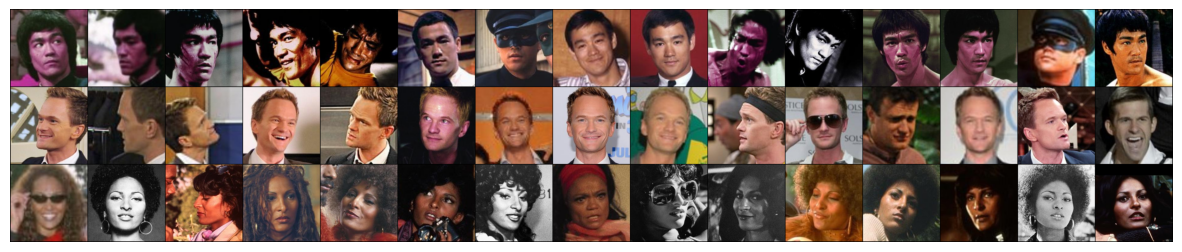

In [ ]:
# Display Images
# Here are the source images of Bruce Lee, Neil Patrick Harris, and Pam Grier

train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder('faces', transform=train_transform)

image_count = len(face_dataset)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=45,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
# @title Image Preprocessing Function
def process_images(image_dir: str, size=256):
  """
  This function returns two tensors for the
  given image dir: one usable for inputting into the
  facenet model, and one that is [0,1] scaled for
  visualizing

  Parameters:
    image_dir: string
      The glob corresponding to images in a directory
    size: int
      Size [default: 256]

  Returns:
    model_tensor: torch.tensor
      A image_count x channels x height x width
      tensor scaled to between -1 and 1,
      with the faces detected and cropped to the center
      using mtcnn
    display_tensor: torch.tensor
      A transformed version of the model
      tensor scaled to between 0 and 1
  """
  mtcnn = MTCNN(image_size=size, margin=32)
  images = []
  for img_path in glob.glob(image_dir):
    img = Image.open(img_path)
    # Normalize and crop image
    img_cropped = mtcnn(img)
    images.append(img_cropped)

  model_tensor = torch.stack(images)
  display_tensor = model_tensor / (model_tensor.max() * 2)
  display_tensor += .5

  return model_tensor, display_tensor

Now that we have our images loaded, we need to preprocess them. To make the images easier for the classifier to learn, we crop them to include just faces.

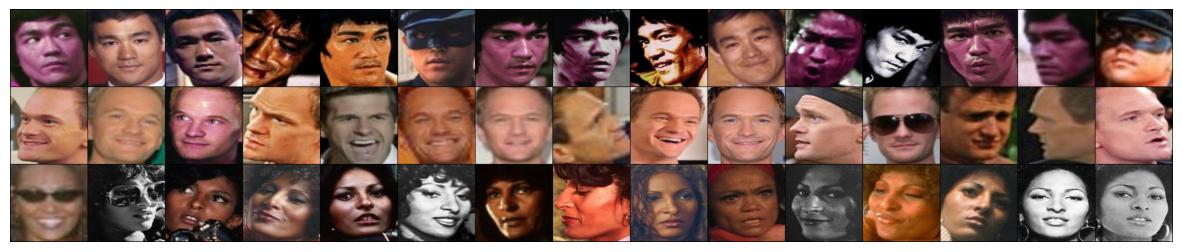

In [ ]:
bruce_tensor, bruce_display = process_images('faces/bruce/*.jpg')
neil_tensor, neil_display = process_images('faces/neil/*.jpg')
pam_tensor, pam_display = process_images('faces/pam/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

---
# Section 2: Data projection

We cannot show 512-dimensional vectors visually, but using **Principal Component Analysis (PCA)** we can project the 512 dimensions onto a 2-dimensional space while preserving the maximum amount of data variation possible. This is just a visual aid for us to understand the concept. Note that if you would like to do any calculation, like distances between two images, this would be done with the whole 512-dimensional embedding vectors.

## Section 2.1 Perform PCA Analysis

**P2:** Conduct Principal Component Analysis (PCA) on the original dataset. - Perform the following tasks:
1. Generate graphs showing eigenvalues and the variance explained.
2. Project the data onto the first two principal directions and plot the 2-D scatter plot using different colors for each image type.
3. Repeat this for the grayscale, black-and-white, and filtered datasets.

**P3:** Write down your observations and conclusions based on these results. What image set generates the best separation between image types in the new projected data?

In [ ]:
#@title CODE HERE

---
# Section 3: Classifier Model

Using the image set with the best results in the previous steps, complete the following tasks:

**P4:** Create a binary decision dataset where the output classifies images as Bruce Lee or not. Train a logistic regression classifier to identify Bruce Lee images.
**P5:** Add noise to the selected dataset and train the classifier again. Analyze and conclude about the impact of noise on bias and variance.


# Deliverables

- Submit the following items:
1. Python scripts used for data processing, transformations, PCA, and classification.
2. Plots and graphs for PCA analysis and classification results.
3. A report summarizing your observations and conclusions for each ste and giving some conclusion

